# Quantum Optimal Control with Reinforcement Learning

In this notebook, we will demonstrate how to use the `_RL` module to solve a quantum optimal control problem using reinforcement learning (RL). We will define a simple state transfer problem with a single qubit, where the goal is to transfer a quantum system from one state to another, and we will use the RL agent to optimize the control pulses to achieve this task.
After we will also see the same problem but using unitary operators

## State to State Transfer



### Setup and Import Required Libraries

In [1]:
# If you are running this in an environment where some packages are missing, use this cell to install them:
# !pip install qutip stable-baselines3 gymnasium

import qutip as qt
import numpy as np
from stable_baselines3 import PPO
#from qutip_qoc import Result, Objective, _TimeInterval
from qutip_qoc import Objective
#from _rl import _RL
import matplotlib.pyplot as plt

In [2]:
#this is just for using local files (not yet merged in github)
import sys
import os

module_path = os.path.abspath(os.path.join('..', 'Github', 'qutip-qoc', 'src', 'qutip_qoc'))

sys.path.append(module_path)

from _rl import _RL
from pulse_optim import optimize_pulses

### Define the Quantum Control Problem

We define the problem of transferring a quantum system from the initial state |0⟩ to the target state |+⟩. The system is controlled via three control Hamiltonians corresponding to the Pauli matrices, and a drift Hamiltonian for natural evolution of the qubit.

In [3]:
# Define the initial and target states
initial_state = qt.basis(2, 0)  # |0⟩
target_state = (qt.basis(2, 0) + qt.basis(2, 1)).unit() # |+⟩
#target_state = qt.basis(2, 1)   # |1⟩

# Define the control Hamiltonians (Pauli matrices)
H_c = [qt.sigmax(), qt.sigmay(), qt.sigmaz()]

# Define the drift Hamiltonian
w, d = 0.1, 1.0
H_d = 1 / 2 * (w * qt.sigmaz() + d * qt.sigmax())

# Combine the Hamiltonians into a single list
H = [H_d] + H_c

# Define the objective
objectives = [Objective(initial=initial_state, H=H, target=target_state)]

# Define the control parameters with bounds
control_parameters = {
    "p": {"bounds": [(-13, 13)]}
}

# Define the time interval
tlist = np.linspace(0, 10, 100)

# Define algorithm-specific settings
algorithm_kwargs = {
    "fid_err_targ": 0.01,
    "alg": "RL",
    "max_iter": 20000,
    "shorter_pulses": True,
}
optimizer_kwargs = {}


Note that `max_iter` defines the number of episodes, the 100 in `tlist` defines the maximum number of steps per episode.  
If `shorter_pulses` is True, the training will be longer as the algorithm will try to optimize the episodes using as few steps as possible in addition to checking if the target infidelity is reached.
If it is False, the algorithm stops as soon as it finds an episode with infidelity <= of the target infidelity

### Initialize and Train the RL Environment

Now we will call the `optimize_pulses()` method, passing it the control problem we defined.
The method will create an instance of the `_RL` class, which will set up the reinforcement learning environment and start training.
Finally it returns the optimization results through an object of the `Result` class.

In [7]:
# Initialize the RL environment and start training
rl_result = optimize_pulses(
    objectives,
    control_parameters,
    tlist,
    algorithm_kwargs,
    optimizer_kwargs
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.92     |
|    ep_rew_mean     | -2.21    |
| time/              |          |
|    fps             | 2282     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | -2.3        |
| time/                   |             |
|    fps                  | 1871        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005770128 |
|    clip_fraction        | 0.0454      |
|    clip_range           | 0.2         |
|    entropy_loss   

### Analyze the Results

After the training is complete, we can analyze the results obtained by the RL agent. 
In the above window showing the output produced by Gymansium, you can observe how during training the number of steps per episode (ep_len_mean) decreases and the average reward of the episodes (ep_rew_mean) increases.

We can now see the fields of the `Result` class, this includes the final infidelity, the optimized control parameters and more.

In [8]:
print(rl_result)

Control Optimization Result
--------------------------
- Started at 2024-08-24 20:38:52
- Number of objectives: 1
- Final fidelity error: 0.0048685058051837204
- Final parameters: [[-10.849769413471222, -12.63647347688675, -13.0], 30.0]
- Number of iterations: 19691
- Reason for termination: Training finished. No episode in the last 100 used fewer steps and infidelity was below target infid.
- Optimized time parameter: 30.0
- Ended at 2024-08-24 20:39:22 (30.0s)


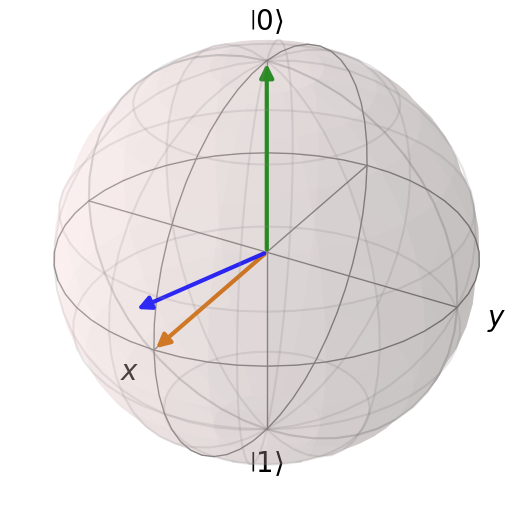

In [9]:
# We can also visualize the initial and final states on the Bloch sphere
bloch_sp = qt.Bloch()
bloch_sp.add_states(initial_state)
bloch_sp.add_states(target_state)
bloch_sp.add_states(rl_result._final_states[0])
bloch_sp.show()

If the total number of iterations in the Result class is slightly higher than the set value, it is because the algorithm needs to complete the rollout, which consists of a certain number of episodes, before performing termination checks (as defined in the Callback class).

## Unitary Operators

Now we will show how to tackle a problem similar to the previous one, but this time, instead of reaching a specific target state, the goal is to start from the identity operator and evolve it in a controlled way until we obtain a specific unitary operator, such as the Hadamard gate.

The control problem is similar to the previous one, we just need to change the initial state, the target state (now they are matrices) and update the objective.  
We can also change the number of episodes for this task by changing `max_iter`  
By setting `shorter_pulses` to False, the algorithm will stop as soon as it finds an episode that satisfies the target infidelity.

In [5]:
initial = qt.qeye(2) # Identity
target  = qt.gates.hadamard_transform()

objectives=[Objective(initial, H, target)]

algorithm_kwargs = {
    "fid_err_targ": 0.01,
    "alg": "RL",
    "max_iter": 900,
    "shorter_pulses": False,
}

In [6]:
# Initialize the RL environment and start training
rl_result = optimize_pulses(
    objectives,
    control_parameters,
    tlist,
    algorithm_kwargs,
    optimizer_kwargs
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -48.4    |
| time/              |          |
|    fps             | 2351     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -48.3       |
| time/                   |             |
|    fps                  | 1878        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004405604 |
|    clip_fraction        | 0.0345      |
|    clip_range           | 0.2         |
|    entropy_loss   

In [7]:
print(rl_result)

Control Optimization Result
--------------------------
- Started at 2024-08-26 19:04:39
- Number of objectives: 1
- Final fidelity error: 0.002551819763576102
- Final parameters: [[3.4188188314437866, 13.0, 13.0], [13.0, 13.0, -13.0], [6.511582612991333, 13.0, 8.964270651340485], [-13.0, 7.0920491218566895, 13.0], [13.0, 13.0, 7.403999388217926], [-7.155267655849457, 6.941469728946686, -0.06780803203582764], [0.3478652387857437, 13.0, -13.0], [0.9450445175170898, 13.0, 10.478427648544312], [-2.7053715586662292, 6.866261005401611, -2.9162583351135254], [-12.548729062080383, 13.0, 0.3780375272035599], [5.524807989597321, -12.404477953910828, -1.3450259938836098], [9.932345569133759, 6.742649078369141, 0.8036832511425018], [10.077520310878754, 10.17627239227295, -0.3489200174808502], [-8.5400710105896, -13.0, 4.9227414727211], [3.7715193927288055, 13.0, -13.0], [-9.494724571704865, -13.0, -12.165066242218018], [-13.0, 0.28259196877479553, -0.2347586750984192], [-13.0, 13.0, -1.19936531782

Text(0.5, 1.0, 'hinton')

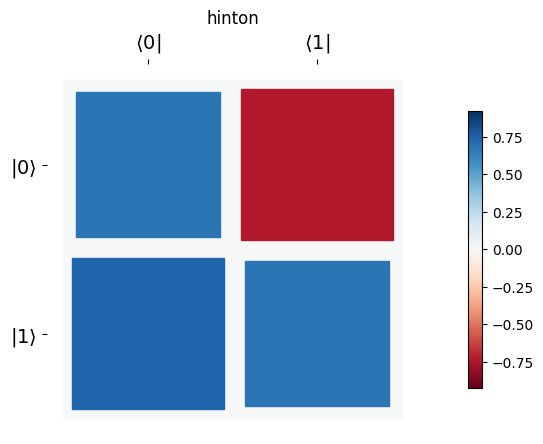

In [8]:
# We can show in this case the hinton matrix
fig, ax = qt.hinton(rl_result._final_states[0])
ax.set_title('hinton')

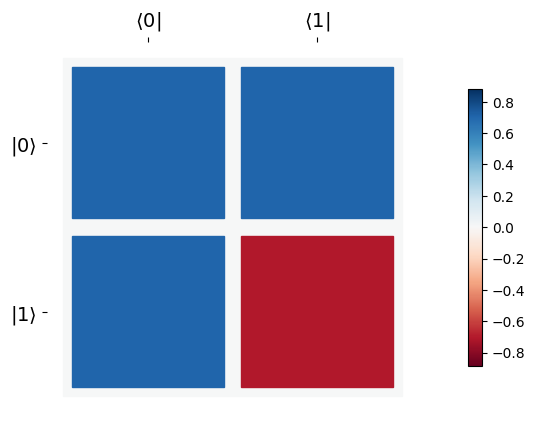

In [10]:
# for the hadamard matrix
U = qt.gates.hadamard_transform()
fig, ax = qt.hinton(U)

We are using PSU norm in the infidelity calculation, so the found transformation is correct, independently of the global phase.